In [1]:
# Add related paths to system path
import sys
sys.path.append("../src")

import numpy as np
import pandas
import matplotlib.pyplot as plt
from models import FDBaseline, PDABaseline, CDABaseline, LinearUCB, LassoBandit
from evaluate import Evaluator

In [2]:
# Load data
data = pandas.read_csv("../data/data.csv", delimiter=',')
print(data.shape)

(5528, 87)


In [3]:
# Define baseline models
fixed = FDBaseline(1) # Define fixed dosage to be 1 (5mg / day)
pharm = PDABaseline()
clinic = CDABaseline()

In [4]:
# Get data for all baselines

# Fixed dosage baseline
fixed_features = fixed.get_features(data)

# Pharmacogenetic dosage baseline
pharm_features = pharm.get_features(data)

# Clinical dosage baseline
clinic_features = clinic.get_features(data)

# Get targets for each set (same targets for each baseline)
targets = fixed.get_targets(data)

In [9]:
# Define evaluators for each model
fixed_eval = Evaluator(fixed)
pharm_eval = Evaluator(pharm)
clinic_eval = Evaluator(clinic)

Fraction of correct decisions: 0.611794500723589


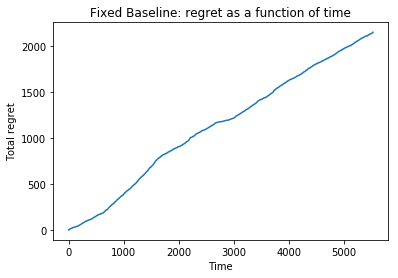

In [10]:
# Evaluate fixed baseline
fixed_predictions = fixed.predict(fixed_features)
fixed_acc = fixed_eval.accuracy(fixed_predictions, targets.values)
print("Fraction of correct decisions: " + str(fixed_acc))

fixed_regret = fixed_eval.regret(fixed_predictions, targets.values)
plt.plot(range(fixed_regret.shape[0]), fixed_regret)
plt.title("Fixed Baseline: regret as a function of time")
plt.xlabel("Time")
plt.ylabel("Total regret")
plt.show()

Fraction of correct decisions: 0.6864387593389178


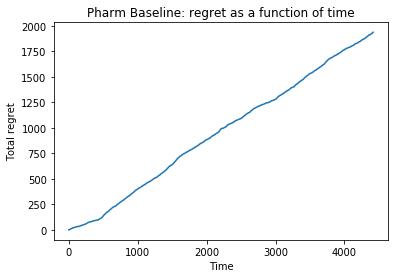

In [7]:
# Evaluate Pharmacogenetic baseline
pharm_predictions = pharm.predict(pharm_features.values[~np.isnan(pharm_features).any(axis=1)])
pharm_acc = pharm_eval.accuracy(pharm_predictions, targets.values[~np.isnan(pharm_features).any(axis=1)])
print("Fraction of correct decisions: " + str(pharm_acc))

pharm_regret = fixed_eval.regret(pharm_predictions, targets.values)
plt.plot(range(pharm_regret.shape[0]), pharm_regret)
plt.title("Pharm Baseline: regret as a function of time")
plt.xlabel("Time")
plt.ylabel("Total regret")
plt.show()

Fraction of correct decisions: 0.649083088068825


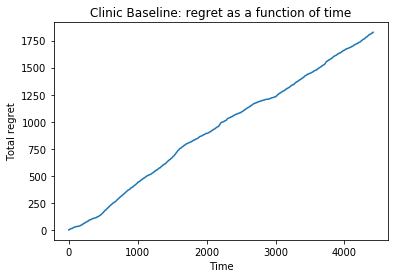

In [8]:
# Evaluate Clinical baseline
clinic_predictions = clinic.predict(clinic_features.values[~np.isnan(clinic_features).any(axis=1)])
clinic_acc = clinic_eval.accuracy(clinic_predictions, targets.values[~np.isnan(clinic_features).any(axis=1)])
print("Fraction of correct decisions: " + str(clinic_acc))

clinic_regret = fixed_eval.regret(clinic_predictions, targets.values)
plt.plot(range(clinic_regret.shape[0]), clinic_regret)
plt.title("Clinic Baseline: regret as a function of time")
plt.xlabel("Time")
plt.ylabel("Total regret")
plt.show()

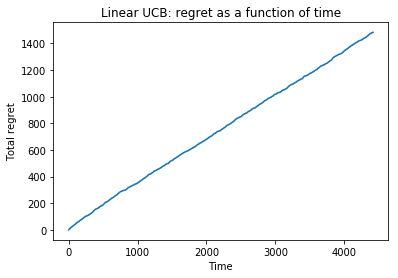

0.6641014033499322


In [12]:
linear_UCB = LinearUCB(num_arms=3, alpha=0.5)
linear_UCB_features = linear_UCB.get_features(data)
linear_UCB_regret, linear_UCB_incorrect = linear_UCB.train(linear_UCB_features.values[~np.isnan(linear_UCB_features).any(axis=1)], targets.values[~np.isnan(linear_UCB_features).any(axis=1)])
plt.plot(range(linear_UCB_regret.shape[0]), linear_UCB_regret)
plt.title("Linear UCB: regret as a function of time")
plt.xlabel("Time")
plt.ylabel("Total regret")
plt.show()

print(1 - linear_UCB_regret[len(linear_UCB_regret) -1] / len(linear_UCB_regret))

In [13]:
print(linear_UCB_incorrect)

[0.5644102331899479, 0.4086484038940457, 0.3875933891781752, 0.3719719266470455, 0.3472945438080145, 0.3432193796694589, 0.3459361557618293, 0.3389178175232058, 0.33506905139234777, 0.33461625537695266, 0.3348426533846502, 0.3352954494000453, 0.3307674892460946, 0.3282771111614218, 0.32918270319221193, 0.32601313108444646, 0.32940910119990946, 0.32261716096898346, 0.3271451211229341, 0.3248811410459588, 0.3230699569843785, 0.3239755490151687, 0.3253339370613539, 0.32737151913063167, 0.32918270319221193, 0.3253339370613539, 0.3255603350690514, 0.3239755490151687, 0.3232963549920761, 0.3239755490151687, 0.3244283450305637, 0.32578673307674894, 0.32601313108444646, 0.3271451211229341, 0.3282771111614218, 0.3264659270998415, 0.3242019470228662, 0.3244283450305637, 0.3239755490151687, 0.3235227529997736, 0.3255603350690514, 0.3255603350690514, 0.32578673307674894, 0.3251075390536563, 0.3244283450305637, 0.3244283450305637]


using random init
using random init
using random init


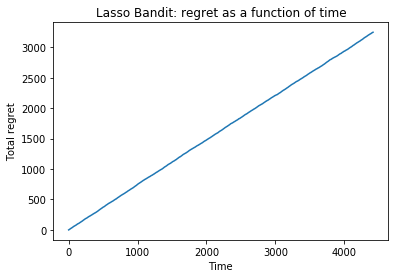

0.2645993662290629


In [7]:
lasso = LassoBandit(num_arms=3, lambda1=0.5, lambda2=0.5, h=0.5, q=3)
lasso_features = lasso.get_features(data)
# lasso_regret, lasso_incorrect = lasso.train(lasso_features.values[~np.isnan(lasso_features).any(axis=1)], targets.values[~np.isnan(lasso_features).any(axis=1)])
lasso_regret = lasso.train(lasso_features.values[~np.isnan(lasso_features).any(axis=1)], targets.values[~np.isnan(lasso_features).any(axis=1)])
plt.plot(range(lasso_regret.shape[0]), lasso_regret)
plt.title("Lasso Bandit: regret as a function of time")
plt.xlabel("Time")
plt.ylabel("Total regret")
plt.show()

print(1 - lasso_regret[len(lasso_regret) -1] / len(lasso_regret))